<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/NU/Attenuation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attenuation model

Evgeny Kolonsky, Oct 2024

v.0.1.11


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import chisquare, poisson, linregress

#Reference data

- $\gamma$ rays: [X-Rays Mass Attenuation Coefficients](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html) NIST
- $\beta$ rays: [Mass absorption coefficients and range of beta particles in Be, AI, Cu, Ag and Pb.](https://www.ias.ac.in/article/fulltext/pram/018/02/0121-0126)  Nathu Ram et al, 1982

In [2]:
I_background = 0.29 # counts / s

GAMMA = {
    'Al':  '''
#     Energy       μ/ρ        μen/ρ
#      (MeV)      (cm2/g)     (cm2/g)
#____________________________________
#
   1.00000E-03  1.185E+03  1.183E+03
   1.50000E-03  4.022E+02  4.001E+02
   1.55960E-03  3.621E+02  3.600E+02
   1.55960E-03  3.957E+03  3.829E+03
   2.00000E-03  2.263E+03  2.204E+03
   3.00000E-03  7.880E+02  7.732E+02
   4.00000E-03  3.605E+02  3.545E+02
   5.00000E-03  1.934E+02  1.902E+02
   6.00000E-03  1.153E+02  1.133E+02
   8.00000E-03  5.033E+01  4.918E+01
   1.00000E-02  2.623E+01  2.543E+01
   1.50000E-02  7.955E+00  7.487E+00
   2.00000E-02  3.441E+00  3.094E+00
   3.00000E-02  1.128E+00  8.778E-01
   4.00000E-02  5.685E-01  3.601E-01
   5.00000E-02  3.681E-01  1.840E-01
   6.00000E-02  2.778E-01  1.099E-01
   8.00000E-02  2.018E-01  5.511E-02
   1.00000E-01  1.704E-01  3.794E-02
   1.50000E-01  1.378E-01  2.827E-02
   2.00000E-01  1.223E-01  2.745E-02
   3.00000E-01  1.042E-01  2.816E-02
   4.00000E-01  9.276E-02  2.862E-02
   5.00000E-01  8.445E-02  2.868E-02
   6.00000E-01  7.802E-02  2.851E-02
   8.00000E-01  6.841E-02  2.778E-02
   1.00000E+00  6.146E-02  2.686E-02
   1.25000E+00  5.496E-02  2.565E-02
   1.50000E+00  5.006E-02  2.451E-02
   2.00000E+00  4.324E-02  2.266E-02
   3.00000E+00  3.541E-02  2.024E-02
   4.00000E+00  3.106E-02  1.882E-02
   5.00000E+00  2.836E-02  1.795E-02
   6.00000E+00  2.655E-02  1.739E-02
   8.00000E+00  2.437E-02  1.678E-02
   1.00000E+01  2.318E-02  1.650E-02
   1.50000E+01  2.195E-02  1.631E-02
   2.00000E+01  2.168E-02  1.633E-02
''',

'Ni': '''
#Energy       μ/ρ        μen/ρ
#      (MeV)      (cm2/g)     (cm2/g)
#____________________________________
#
   1.00000E-03  9.855E+03  9.797E+03
   1.00404E-03  9.753E+03  9.697E+03
   1.00810E-03  9.654E+03  9.598E+03
   1.00810E-03  1.099E+04  1.093E+04
   1.50000E-03  4.234E+03  4.214E+03
   2.00000E-03  2.049E+03  2.039E+03
   3.00000E-03  7.094E+02  7.042E+02
   4.00000E-03  3.282E+02  3.244E+02
   5.00000E-03  1.793E+02  1.761E+02
   6.00000E-03  1.090E+02  1.064E+02
   8.00000E-03  4.952E+01  4.758E+01
   8.33280E-03  4.428E+01  4.242E+01
   8.33280E-03  3.294E+02  2.240E+02
   1.00000E-02  2.090E+02  1.524E+02
   1.50000E-02  7.081E+01  5.734E+01
   2.00000E-02  3.220E+01  2.722E+01
   3.00000E-02  1.034E+01  8.982E+00
   4.00000E-02  4.600E+00  3.967E+00
   5.00000E-02  2.474E+00  2.078E+00
   6.00000E-02  1.512E+00  1.219E+00
   8.00000E-02  7.306E-01  5.259E-01
   1.00000E-01  4.440E-01  2.781E-01
   1.50000E-01  2.208E-01  9.812E-02
   2.00000E-01  1.582E-01  5.649E-02
   3.00000E-01  1.154E-01  3.659E-02
   4.00000E-01  9.765E-02  3.209E-02
   5.00000E-01  8.698E-02  3.036E-02
   6.00000E-01  7.944E-02  2.937E-02
   8.00000E-01  6.891E-02  2.795E-02
   1.00000E+00  6.160E-02  2.674E-02
   1.25000E+00  5.494E-02  2.536E-02
   1.50000E+00  5.015E-02  2.420E-02
   2.00000E+00  4.387E-02  2.257E-02
   3.00000E+00  3.745E-02  2.107E-02
   4.00000E+00  3.444E-02  2.066E-02
   5.00000E+00  3.289E-02  2.070E-02
   6.00000E+00  3.210E-02  2.094E-02
   8.00000E+00  3.164E-02  2.163E-02
   1.00000E+01  3.185E-02  2.234E-02
   1.50000E+01  3.320E-02  2.368E-02
   2.00000E+01  3.476E-02  2.446E-02
''',

'Pb': '''
#Energy       μ/ρ        μen/ρ
#      (MeV)      (cm2/g)     (cm2/g)
#____________________________________
#
   1.00000E-03  5.210E+03  5.197E+03
   1.50000E-03  2.356E+03  2.344E+03
   2.00000E-03  1.285E+03  1.274E+03
   2.48400E-03  8.006E+02  7.895E+02
   2.48400E-03  1.397E+03  1.366E+03
   2.53429E-03  1.726E+03  1.682E+03
   2.58560E-03  1.944E+03  1.895E+03
   2.58560E-03  2.458E+03  2.390E+03
   3.00000E-03  1.965E+03  1.913E+03
   3.06640E-03  1.857E+03  1.808E+03
   3.06640E-03  2.146E+03  2.090E+03
   3.30130E-03  1.796E+03  1.748E+03
   3.55420E-03  1.496E+03  1.459E+03
   3.55420E-03  1.585E+03  1.546E+03
   3.69948E-03  1.442E+03  1.405E+03
   3.85070E-03  1.311E+03  1.279E+03
   3.85070E-03  1.368E+03  1.335E+03
   4.00000E-03  1.251E+03  1.221E+03
   5.00000E-03  7.304E+02  7.124E+02
   6.00000E-03  4.672E+02  4.546E+02
   8.00000E-03  2.287E+02  2.207E+02
   1.00000E-02  1.306E+02  1.247E+02
   1.30352E-02  6.701E+01  6.270E+01
   1.30352E-02  1.621E+02  1.291E+02
   1.50000E-02  1.116E+02  9.100E+01
   1.52000E-02  1.078E+02  8.807E+01
   1.52000E-02  1.485E+02  1.131E+02
   1.55269E-02  1.416E+02  1.083E+02
   1.58608E-02  1.344E+02  1.032E+02
   1.58608E-02  1.548E+02  1.180E+02
   2.00000E-02  8.636E+01  6.899E+01
   3.00000E-02  3.032E+01  2.536E+01
   4.00000E-02  1.436E+01  1.211E+01
   5.00000E-02  8.041E+00  6.740E+00
   6.00000E-02  5.021E+00  4.149E+00
   8.00000E-02  2.419E+00  1.916E+00
   8.80045E-02  1.910E+00  1.482E+00
   8.80045E-02  7.683E+00  2.160E+00
   1.00000E-01  5.549E+00  1.976E+00
   1.50000E-01  2.014E+00  1.056E+00
   2.00000E-01  9.985E-01  5.870E-01
   3.00000E-01  4.031E-01  2.455E-01
   4.00000E-01  2.323E-01  1.370E-01
   5.00000E-01  1.614E-01  9.128E-02
   6.00000E-01  1.248E-01  6.819E-02
   8.00000E-01  8.870E-02  4.644E-02
   1.00000E+00  7.102E-02  3.654E-02
   1.25000E+00  5.876E-02  2.988E-02
   1.50000E+00  5.222E-02  2.640E-02
   2.00000E+00  4.606E-02  2.360E-02
   3.00000E+00  4.234E-02  2.322E-02
   4.00000E+00  4.197E-02  2.449E-02
   5.00000E+00  4.272E-02  2.600E-02
   6.00000E+00  4.391E-02  2.744E-02
   8.00000E+00  4.675E-02  2.989E-02
   1.00000E+01  4.972E-02  3.181E-02
   1.50000E+01  5.658E-02  3.478E-02
#   2.00000E+01  6.206E-02  3.595E-02
'''    }

# Digitized data from Nathu et al. paper
BETA = {
'Al': '''
# Emax/MeV, mu cm2/g
0.127	365.402
0.140	327.455
0.156	281.979
0.167	245.251
0.182	215.443
0.202	189.259
0.218	174.753
0.238	147.513
0.270	123.285
0.300	104.068
0.327	88.726
0.389	71.969
0.420	62.595
0.476	52.838
0.514	46.416
0.577	39.970
0.630	34.764
0.687	30.844
0.735	28.480
0.809	24.525
0.849	22.421
0.944	19.696
1.019	17.130
1.112	15.048
1.213	13.088
1.322	11.384
1.470	10.100
1.619	8.962
1.817	7.342
1.982	6.259
2.161	5.609
2.380	4.688
2.596	4.243
2.777	3.765
3.028	3.307
3.302	2.934
3.533	2.604
3.707	2.428
''',
'Pb': '''
# Emax/MeV, mu cm2/g
0.144	441.180
0.166	380.190
0.188	310.676
0.231	243.307
0.261	188.532
0.299	157.370
0.349	125.893
0.411	99.646
0.447	89.600
0.485	80.566
0.490	79.715
0.533	68.695
0.603	58.572
0.675	49.942
0.765	43.497
0.848	37.884
0.950	31.288
1.042	26.963
1.180	22.990
1.281	20.893
1.435	17.440
1.625	14.713
2.039	10.251
2.430	7.859
2.808	6.701
3.146	5.775
3.488	4.769
3.908	4.110
4.333	3.696
5.111	2.864
'''
}

def get_Emu(material, rays='gamma'):
  if rays == 'gamma':
    E_, murho_, muen_ =  np.genfromtxt(GAMMA[material].splitlines(), unpack=True)
  elif rays == 'beta':
    E_, murho_ =  np.genfromtxt(BETA[material].splitlines(), unpack=True)
  return E_, murho_

get_Emu('Al', 'gamma')
get_Emu('Ni',  'gamma')
get_Emu('Pb',  'gamma')
get_Emu('Al', 'beta')
get_Emu('Pb', 'beta');

Energy spectrum interval

In [3]:
EMAX = 2.0 # MeV
EMIN = 2.5e-3 #MeV
N = 1000
Espace = np.linspace(EMIN, EMAX, N)

## Interpolating $\mu$ for any arbitrary energy

In [4]:
# interpolate mu from reference data tables
# we will use linear interpolation in logarythic scale

def mu_interpolate(energy, material, rays ):
  ans = []
  E_, mu_ = get_Emu(material, rays)
  lE_ = np.log(E_)
  lmu_ = np.log(mu_)
  lenergy = np.log(energy)
  for en in lenergy:
    for i in range(len(lE_) - 1):
      if en < lE_[i+1] and en >= lE_[i]:
        break
    ldmu = lmu_[i+1] - lmu_[i]
    ldE  = lE_[i+1] - lE_[i]
    lmu_interpolated = lmu_[i] + ldmu * (en - lE_[i]) / ldE
    ans.append(lmu_interpolated)
  return np.exp(np.array(ans))

# Example usage
print( mu_interpolate([2.280], material='Al', rays='beta') )
print( mu_interpolate(np.array([ 0.762]), material='Pb', rays='beta') )
print( mu_interpolate(np.array([ 0.667]), material='Al', rays='gamma') )

[5.07723766]
[43.68608312]
[0.07433605]


## Interpolating energy in MeV for known $\mu$

In [5]:
def energy_interpolate(mu_rho, material, rays ):
  ans = []
  E_, mu_ = get_Emu(material, rays)
  lE_ = np.log(E_)
  lmu_ = np.log(mu_)
  lmu = np.log(mu_rho)
  for mu in lmu:
    for i in range(len(lmu_) - 1):
      if mu > lmu_[i+1] and mu <= lmu_[i]:
        break
    ldmu = lmu_[i+1] - lmu_[i]
    ldE  = lE_[i+1] - lE_[i]
    len_interpolated = lE_[i] + ldE * (mu - lmu_[i]) / ldmu
    ans.append(len_interpolated)
  return np.exp(np.array(ans))


print( energy_interpolate([0.06, 0.05], material='Al', rays='gamma') )
E_, mu_ = get_Emu('Al', 'gamma')
#for i, e in enumerate(E_):
#  print(i, E_[i], mu_[i])

[1.04916439 1.50353776]


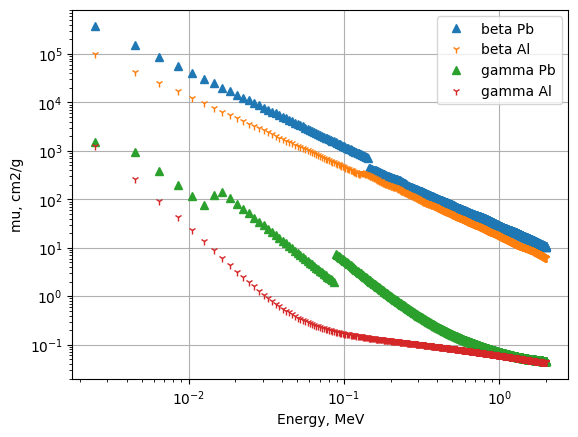

In [6]:
rays = 'beta'

mu_spectrum_gamma = mu_interpolate(Espace, material='Pb', rays=rays)
mu_spectrum_beta = mu_interpolate(Espace, material='Al', rays=rays)
plt.plot(Espace, mu_spectrum_gamma, '^', label=f'{rays} Pb')
plt.plot(Espace, mu_spectrum_beta, '1', label=f'{rays} Al')

rays = 'gamma'

mu_spectrum_gamma = mu_interpolate(Espace, material='Pb', rays=rays)
mu_spectrum_beta = mu_interpolate(Espace, material='Al', rays=rays)
plt.plot(Espace, mu_spectrum_gamma, '^', label=f'{rays} Pb')
plt.plot(Espace, mu_spectrum_beta, '1', label=f'{rays} Al')


plt.xlabel('Energy, MeV')
plt.ylabel(f'mu, cm2/g')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')

# Functions for repetetive actions

In [7]:
# function for rounding value by meaningful digits
# with respect to rounded error meaningful digit

def round_meaningful(value, error):
  if error <=0:
    # return unchanged and break
    return value, error

  # Power of error
  power_err = int(np.floor(np.log10(error)))

  # Digits of error in format a.bcd
  n_err = error / (10**np.floor(power_err))

  # keep 2-digits only for errors like 1.0, 1.1
  # otherwise round it up
  if n_err >= 1.2:
    n_err = np.ceil(n_err)
    error = n_err * 10** power_err

  error_rounded = np.round(error, -power_err)
  value_rounded = np.round(value, -power_err)

  return value_rounded, error_rounded

# Fit mu/rho.
# take linear part of data defined by Condition
# find fit.slope and fit offset of Intensity/I0 log on logarythmic scale \mu
# matter is either Al (aluminium) or Pb (lead).
# divide by matter density rho
# return fit, mu/rho and mu/rho uncertainty.

RHO = {'Pb':11.35, 'Al':2.7} # g/cm3

def get_murho(condition, d_rho, I_rel):

  logI = np.log(I_rel[condition])
  x = d_rho[condition]
  fit = linregress(x, logI)
  mu_rho = - fit.slope
  mu_rho_err = fit.stderr
  # uncertainty
  mu_rho, mu_rho_err = round_meaningful(mu_rho, mu_rho_err)
  return mu_rho, mu_rho_err, fit




# Comparison of reference $\mu$ data with illustration in literature

[*Elements of X-Ray Diffraction*](https://www.eng.uc.edu/~beaucag/Classes/AdvancedMaterialsThermodynamics/Books/B.D.%20Cullity,%20S.R.%20Stock%20-%20Elements%20of%20X-Ray%20Diffraction-Pearson%20Education%20Limited%20(2014).pdf\\): B.D. Cullity S.R. Stock Third Edition, p.12

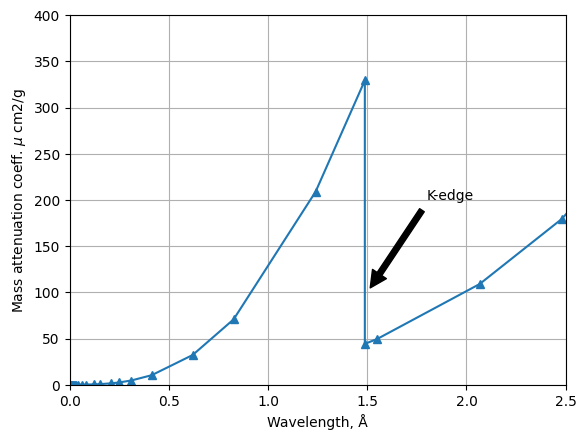

In [8]:
E, mu = get_Emu('Ni')
l = 12.398e-3 / E

plt.plot(l, mu, '-^')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Wavelength, Å')
plt.xlim(0, 2.5)
plt.ylim(0, 400)
plt.ylabel(r'Mass attenuation coeff. $\mu$ cm2/g')
plt.annotate('K-edge', xy=(1.5, 100), xytext=(1.8, 200), arrowprops=dict(facecolor='black', shrink=0.05))
plt.grid()
plt.show()

Figure shows K absorbption edge at wavelength 1.5 Angsrom in Nickel, exactly as on Fig.8 in "Elements of X-Ray Diffraction" book.

---



# $\beta$-decay energy spectrum

<img src='https://upload.wikimedia.org/wikipedia/commons/e/e6/Beta_spectrum_of_RaE.jpg' width=300>

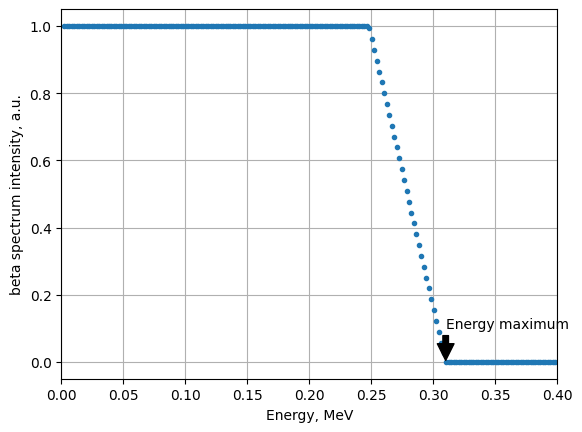

In [9]:
def zero_spectrum():
  I = Espace * 0
  return I


def beta_spectrum(Emax):
  Emid = Emax * 0.8 # intensity maximum energy coordinate
  I  = zero_spectrum()
  mask = Espace >= Emid
  I[mask] =  (1 - Espace[mask]/Emax) * Emax / (Emax - Emid) # rude approximation by lines
  mask = Espace < Emid
  I[mask] = 1 # Espace[mask] / Emid
  I[I < 0] = 0
  return I

# delta-function
def gamma_spectrum(Energy):
  I  = zero_spectrum()
  index = np.argmin(np.abs(np.array(Espace)-Energy))
  I[index] =  Energy
  return I

# usage example

beta_Emax = 0.31
gamma_Energy = 1.173
plt.plot(Espace, beta_spectrum(beta_Emax), '.')
plt.xlabel('Energy, MeV')
plt.ylabel('beta spectrum intensity, a.u.')
plt.xlim(0.0, 0.4)
plt.annotate('Energy maximum', xy=(beta_Emax, 0), xytext=(beta_Emax, 0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.grid()
#plt.xscale('log')
#plt.yscale('log')



# Cobalt-60 vs Pb




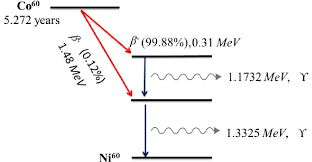

In [10]:
# Cobalt-60
material = 'Pb'
depth_max = 1.75 #cm, lead plates maximum width
rho = 11.35 # Pb density g/cm3

I0_beta = beta_spectrum(0.31)
I0_gamma = zero_spectrum()
I0_gamma += gamma_spectrum(1.173)
#I0_gamma += gamma_spectrum(1.332)

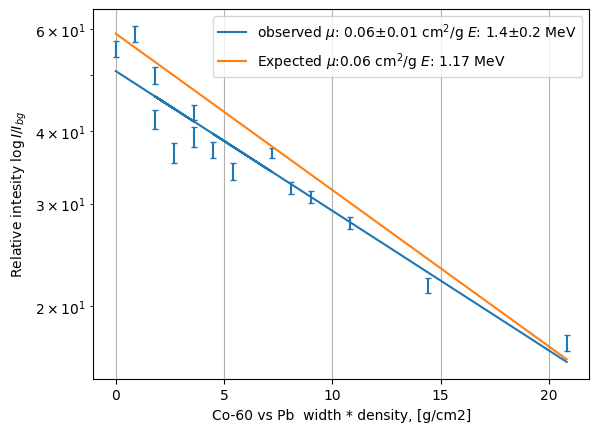

In [11]:
# Experimental data
URL = 'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_28/'
filename = f'{URL}Co-60_3.txt'
data = np.genfromtxt( filename)
d, time, counts = data.T
d *= 1e-4 # um -> cm
delta = 1/np.sqrt(counts) # relative error
I = counts / time
I_rel = I / I_background # relative
I_err = delta * I_rel
log_I_rel = I_err / I_rel # error of log

d_rho = d * RHO['Pb']

plt.errorbar(d_rho, I_rel, yerr=I_err, linestyle='', capsize=2)
WIDTH = np.max(d) # cm
condition = d <= WIDTH # exponential decay part
mu_rho, mu_rho_err, fit = get_murho(condition, d_rho, I_rel)
energy_interval = energy_interpolate([mu_rho-mu_rho_err, mu_rho+mu_rho_err], 'Pb', 'gamma')
energy = np.mean(energy_interval)
energy_err = np.abs(energy_interval[0] - energy_interval[1])/2
mu_txt = f'$\mu$: {mu_rho:.2f}±{mu_rho_err:.2f} cm$^2$/g'
en_txt = f'$E$: {energy:.1f}±{energy_err:.1f} MeV'
plt.plot(d_rho[condition], np.exp(fit.intercept + fit.slope * d_rho[condition]),
          color=plt.gca().lines[-1].get_color(), # get last color
          label=fr'observed {mu_txt} {en_txt}')



total_beta = np.array([])
total_gamma = np.array([])
drs = np.linspace(0, np.max(d_rho), 100)
for dr in drs:
  s = np.sum(I0_gamma * np.exp(- mu_spectrum_gamma * dr) )
  total_gamma = np.append(total_gamma, s )
  s = np.sum(I0_beta * np.exp(- mu_spectrum_beta * dr) )
  total_beta = np.append(total_beta, s )

#total_beta /= I_background
total_gamma /= ( np.max(total_gamma) / np.max(I_rel))



slope, bias = np.polyfit(drs, np.log(total_gamma), 1)
mu_rho_expected = - slope
energy_expected = energy_interpolate([mu_rho_expected], 'Pb', 'gamma')[0]
mu_txt = f'$\mu$:{mu_rho_expected:.2f} cm$^2$/g'
en_txt = f'$E$: {energy_expected:.2f} MeV'

plt.plot(drs, total_gamma, label=f'Expected {mu_txt} {en_txt}')




#plt.axhline(0, color='green', label='Background')
plt.yscale('log')
#plt.ylim(1, np.max(I_rel))
plt.xlabel('Co-60 vs Pb  width * density, [g/cm2]')
plt.ylabel(r'Relative intesity $\log I/I_{bg}$')
plt.grid()

plt.legend()

Beta-radiation has to be immediately absorbed by lead due to high $\mu$ coefficient of $\beta$ absorbtion in lead; but we do not see even slight drop in radiation intensity when we start adding lead plates. We can suggest that even though $\beta$-decay is shown on the decay scheme, this radiation is not observable in the experiment. All intensity counted by Geiger-Muller is due to gamma radiation. The expected intensity attenuation fits rather good with measured data.

#Th-204 vs Al

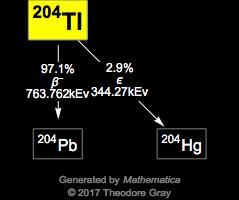

In [12]:
# Thallium-204
material = 'Al'
depth_max = 0.1 #cm
rho = 2.7 # g/cm3

I0_beta  = zero_spectrum()
I0_beta += beta_spectrum(0.763)
#I0_beta += beta_spectrum(0.344)
mu_spectrum_beta = mu_interpolate(Espace, material=material, rays='beta')


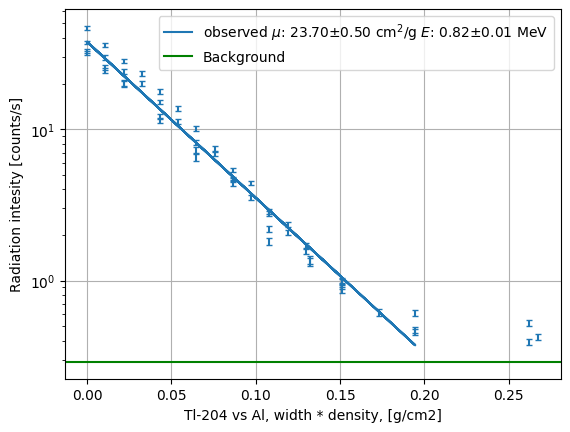

In [13]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_28/'

d, counts, time = np.array([]), np.array([]), np.array([])
for num in [2, 3, 5, 7]:
  filename = f'{URL}Tl-204_{num}.txt'
  d_, counts_, time_ = np.genfromtxt(filename, unpack=True)
  d = np.append(d, d_)
  counts = np.append(counts, counts_)
  time = np.append(time, time_)


d = d * 1e-1 # mm -> cm
delta = 1/np.sqrt(counts) # relative error
I = counts / time
I_rel = I / 1 # relative
I_err = delta * I_rel

d_rho = d * RHO['Al']

plt.errorbar(d_rho, I_rel, capsize=2, yerr=I_err, linestyle='')

WIDTH = 0.2 # g/cm2
condition = d_rho <= WIDTH # exponential decay part
mu_rho, mu_rho_err, fit = get_murho(condition, d_rho, I_rel)
energy_interval = energy_interpolate([mu_rho-mu_rho_err, mu_rho+mu_rho_err], 'Al', 'beta')
energy = np.mean(energy_interval)
energy_err = np.abs(energy_interval[0] - energy_interval[1])/2
mu_txt = f'$\mu$: {mu_rho:.2f}±{mu_rho_err:.2f} cm$^2$/g'
en_txt = f'$E$: {energy:.2f}±{energy_err:.2f} MeV'
plt.plot(d_rho[condition], np.exp(fit.intercept + fit.slope * d_rho[condition]),
          color=plt.gca().lines[-1].get_color(), # get last color
          label=fr'observed {mu_txt} {en_txt}')




drs = np.linspace(0, np.max(d_rho), 20)
intensity = [ np.sum(I0_beta * np.exp(- mu_spectrum_beta * x) )
              for x in drs ]

intensity /= np.max(intensity)

slope, bias = np.polyfit(drs, np.log(intensity), 1)
mu_rho_expected = - slope
energy_expected = energy_interpolate([mu_rho_expected], 'Al', 'beta')[0]
mu_txt = f'$\mu$:{mu_rho_expected:.2f} cm$^2$/g'
en_txt = f'$E$: {energy_expected:.2f} MeV'

#plt.plot(drs, intensity, label=f'Expected {mu_txt} {en_txt}')
plt.axhline(I_background, color='green', label='Background')

plt.yscale('log')
plt.xlabel('Tl-204 vs Al, width * density, [g/cm2]')
plt.ylabel(r'Radiation intesity [counts/s]')
plt.grid()
plt.legend()


Observed intensity attenuation in Al and corresponding $\beta$-decay energy level 820+-10 keV is the same order but sligthly higher than known maximum energy 764 keV. Due the continious energy spectrum of  $\beta$-decay with averaga energy less than maximum , we would rather expect to see non-linear decrease in log axis with effective $\mu$ and energy less than maximum.

The other observation for which we do not have good explanation is that intensity stabilizes at level higher than background.

#Strontium-90 vs. Al

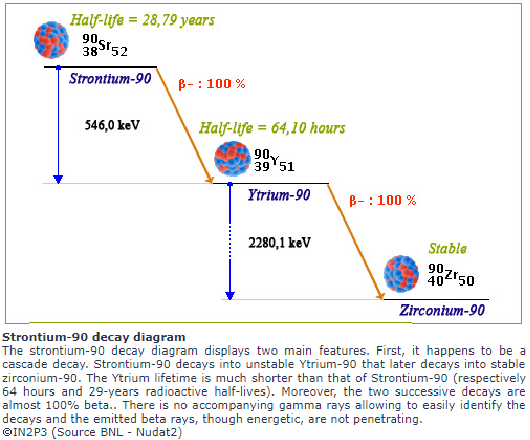

This is a pure $\beta$-source with two $\beta$-emissons. Source: The experiment manual  ([pdf](https://cdn.web.uta.edu/-/media/project/website/science/physics/documents/degree-programs/physics-lab/nuclear-lab/lab-absorption-of-beta-particles.ashx))

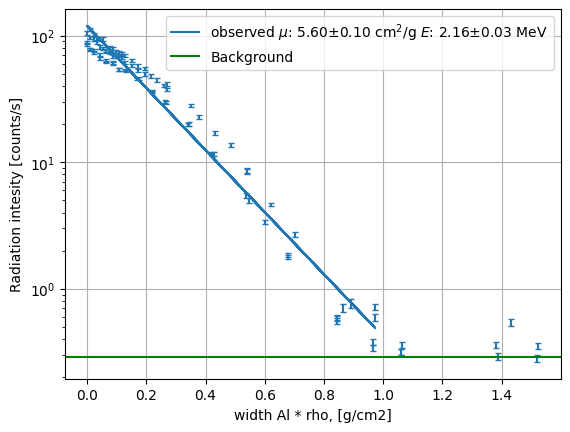

In [17]:
material = 'Al'
depth_max = 0.4 #cm
rho = 2.7 # g/cm3

URL = 'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_26/'

d, counts, time = np.array([]), np.array([]), np.array([])
for num in [4, 5, 6, 3]:
  filename = f'{URL}sr-90-{num}.txt'
  d_, counts_, time_ = np.genfromtxt(filename, unpack=True)
  d = np.append(d, d_)
  counts = np.append(counts, counts_)
  time = np.append(time, time_)


d = d * 1e-1 # mm -> cm
delta = 1/np.sqrt(counts) # relative error
I = counts / time
I_rel = I / 1 # relative
I_err = delta * I_rel

d_rho = d * RHO['Al']

plt.errorbar(d_rho, I_rel, capsize=2, yerr=I_err, linestyle='')

WIDTH = 1.0 # g/cm2
condition = d_rho <= WIDTH # exponential decay part
mu_rho, mu_rho_err, fit = get_murho(condition, d_rho, I_rel)
energy_interval = energy_interpolate([mu_rho-mu_rho_err, mu_rho+mu_rho_err], 'Al', 'beta')
energy = np.mean(energy_interval)
energy_err = np.abs(energy_interval[0] - energy_interval[1])/2
mu_txt = f'$\mu$: {mu_rho:.2f}±{mu_rho_err:.2f} cm$^2$/g'
en_txt = f'$E$: {energy:.2f}±{energy_err:.2f} MeV'
plt.plot(d_rho[condition], np.exp(fit.intercept + fit.slope * d_rho[condition]),
          color=plt.gca().lines[-1].get_color(), # get last color
          label=fr'observed {mu_txt} {en_txt}')

plt.axhline(I_background, color='green', label='Background')

plt.yscale('log')
plt.xlabel('width Al * rho, [g/cm2]')
plt.ylabel(r'Radiation intesity [counts/s]')
plt.grid()
plt.legend()


Observed attenuation and corresponding energy level 2.16+-0.03 MeV reasonably close to known $\beta$-decay maximum energy of Sr-90 2.28 MeV.

When reaching background level the intensity curve stabilizies, as expected.

Strange thing here is curve convexity: we observe upwards convexity, as if the attenuation decreases slowly up to 1mm Al depth, and after that starts decrease quickly with Al depth. We can not explain this. We would expect vice-versa behaviour: quick decrease due to low-energy part of beta spectrum and after loose of low-energy part relatively slow decrease at high-energy part of beta-spectrum (Knoll).

#Cs-137 vs. Al

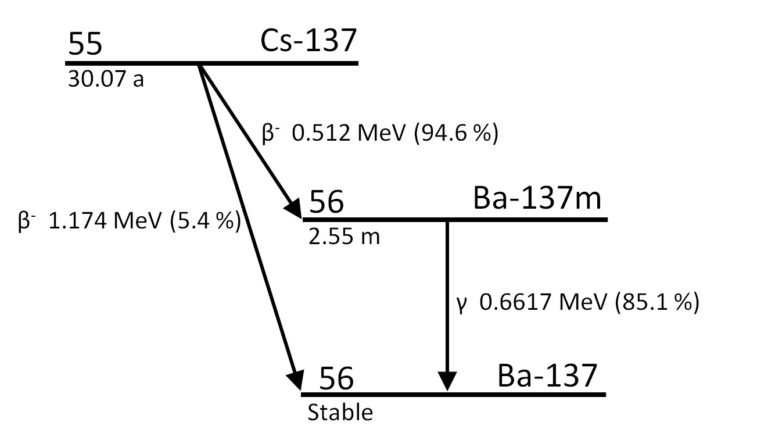

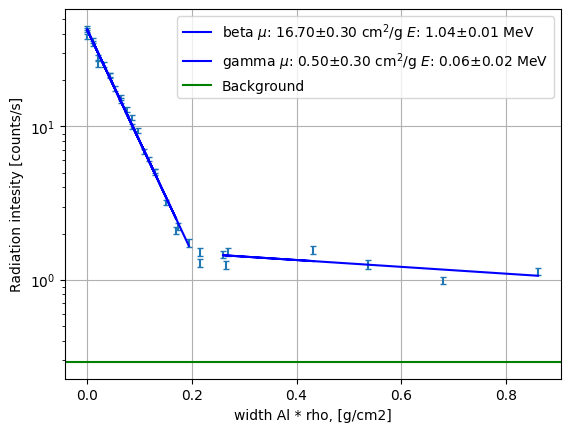

In [15]:
material = 'Al'
rho = 2.7 # g/cm3


############################################################
# measurements

d, counts, time = np.array([]), np.array([]), np.array([])

URL = 'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_28/'
for num in [5, 'x']:
  filename = f'{URL}Cs-137_{num}.txt'
  d_, counts_, time_ = np.genfromtxt(filename, unpack=True)
  d = np.append(d, d_)
  counts = np.append(counts, counts_)
  time = np.append(time, time_)

d = d * 1e-1 # mm -> cm
delta = 1/np.sqrt(counts) # relative error
I = counts / time
I_rel = I  # relative
I_err = delta * I_rel

d_rho = d * RHO['Al']
plt.errorbar(d_rho, I_rel, capsize=2, yerr=I_err, linestyle='')


WIDTH = 0.2 # g/cm2
condition = d_rho <= WIDTH # exponential decay part
mu_rho, mu_rho_err, fit = get_murho(condition, d_rho, I_rel)
energy_interval = energy_interpolate([mu_rho-mu_rho_err, mu_rho+mu_rho_err], 'Al', 'beta')
energy = np.mean(energy_interval)
energy_err = np.abs(energy_interval[0] - energy_interval[1])/2
mu_txt = f'$\mu$: {mu_rho:.2f}±{mu_rho_err:.2f} cm$^2$/g'
en_txt = f'$E$: {energy:.2f}±{energy_err:.2f} MeV'
plt.plot(d_rho[condition], np.exp(fit.intercept + fit.slope * d_rho[condition]),
          color='blue',
          label=fr'beta {mu_txt} {en_txt}')

WIDTH = 0.22 # g/cm2
condition = d_rho >= WIDTH # exponential decay part
mu_rho, mu_rho_err, fit = get_murho(condition, d_rho, I_rel)
energy_interval = energy_interpolate([mu_rho-mu_rho_err, mu_rho+mu_rho_err], 'Al', 'gamma')
energy = np.mean(energy_interval)
energy_err = np.abs(energy_interval[0] - energy_interval[1])/2
mu_txt = f'$\mu$: {mu_rho:.2f}±{mu_rho_err:.2f} cm$^2$/g'
en_txt = f'$E$: {energy:.2f}±{energy_err:.2f} MeV'
plt.plot(d_rho[condition], np.exp(fit.intercept + fit.slope * d_rho[condition]),
          color='blue',
          label=fr'gamma {mu_txt} {en_txt}')

plt.axhline(I_background, color='green', label='Background')




plt.yscale('log')
plt.xlabel('width Al * rho, [g/cm2]')
plt.ylabel(r'Radiation intesity [counts/s]')
plt.grid()
plt.legend(loc='upper right')



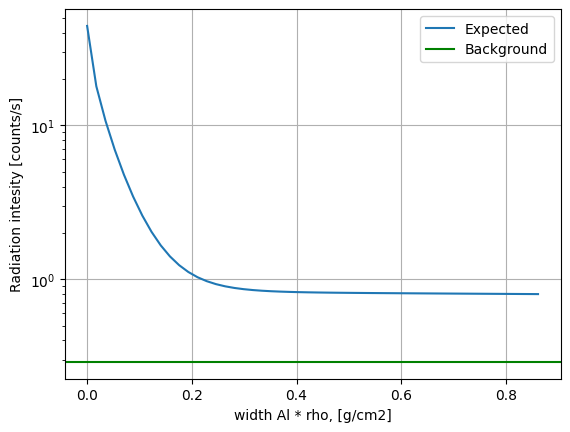

In [16]:
I0_beta  = zero_spectrum()
#I0_beta += beta_spectrum(0.512)
I0_beta += beta_spectrum(1.174)
I0_gamma = zero_spectrum()
I0_gamma += gamma_spectrum(0.6617)

mu_spectrum_beta = mu_interpolate(Espace, material=material, rays='beta')
mu_spectrum_gamma = mu_interpolate(Espace, material=material, rays='gamma')

total_beta = np.array([])
total_gamma = np.array([])
drs = np.linspace(0, np.max(d_rho))
for depth in drs:
  s = np.sum(I0_gamma * np.exp(- mu_spectrum_gamma * depth) )
  total_gamma = np.append(total_gamma, s )
  s = np.sum(I0_beta * np.exp(- mu_spectrum_beta * depth) )
  total_beta = np.append(total_beta, s )

weight_beta = 1 #  beta weight
weight_gamma = 10 # gamma weight
total_intensity = total_beta * weight_beta + total_gamma * weight_gamma
total_intensity /= ( np.max(total_intensity) / np.max(I_rel))
total_intensity += I_background
#plt.plot(depths, total_beta , label='Expected beta')
#plt.plot(depths, total_gamma, label='Expected gamma')
plt.plot(drs, total_intensity, label='Expected')

plt.axhline(I_background, color='green', label='Background')

plt.yscale('log')
plt.xlabel('width Al * rho, [g/cm2]')
plt.ylabel(r'Radiation intesity [counts/s]')
plt.grid()
plt.legend()


Radiation in this case seems to be a weighted composition of $\beta$-decay with energy ~1.174 MeV and $\gamma$-decay at energy level 0.6617 MeV.  

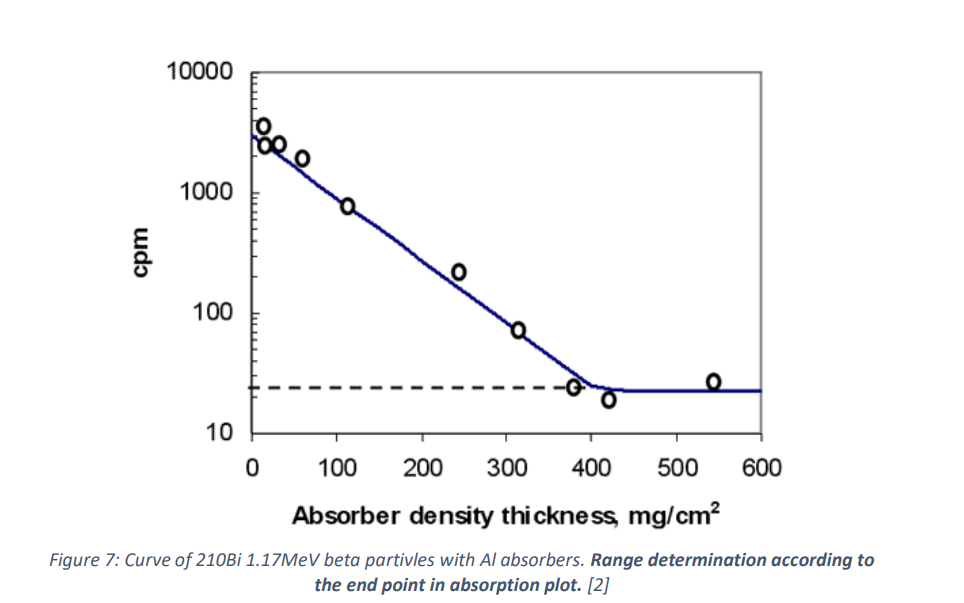